### <p style="text-align: center;"> $\Pi$-Kimono </p>

In [2]:
!export PYTHONPATH="$PWD"
import time

***WARNING : Please check before running this notebook that parameters.NDICES = 8***

# Markov decision process for one turn game

We define several classes to build up our markov decision process, the first is the state class. A state is the data of a sorted tuple representing the dice launch, a frozenset (for hash) to represent the picked numbers, the current score and a boolean to specify if the game is over. As an example we instantiate the initial state with dices (1,3,3,3,4,4,5,W). Notice that for us the worm is represented by 0.

In [4]:
from src.value_iteration.state import State

dices = (0, 1, 3, 3, 3, 4, 4, 5)
picked = ()
score = 0
stop = False

state = State(dices,picked,score,stop)
state.printState()

Dices : (0, 1, 3, 3, 3, 4, 4, 5) | already picked dices : () | score : 0


We can also compute all the next possible states and their probability of happening under some action :

In [5]:
L = state.nextStates()    
for i in range(len(L)):
    states = L[i][0]
    probas = L[i][1]
    print('Next possible states picking dice :',i)
    for j in range(len(states)):
        print('   With proba',probas[j],': ',end='')
        states[j].printState()

Next possible states picking dice : 0
   With proba 3.5722450845907622e-06 : Dices : (5, 5, 5, 5, 5, 5, 5) | already picked dices : (0,) | score : 5
   With proba 2.5005715592135334e-05 : Dices : (4, 5, 5, 5, 5, 5, 5) | already picked dices : (0,) | score : 5
   With proba 7.5017146776406e-05 : Dices : (4, 4, 5, 5, 5, 5, 5) | already picked dices : (0,) | score : 5
   With proba 0.00012502857796067667 : Dices : (4, 4, 4, 5, 5, 5, 5) | already picked dices : (0,) | score : 5
   With proba 0.00012502857796067667 : Dices : (4, 4, 4, 4, 5, 5, 5) | already picked dices : (0,) | score : 5
   With proba 7.5017146776406e-05 : Dices : (4, 4, 4, 4, 4, 5, 5) | already picked dices : (0,) | score : 5
   With proba 2.5005715592135334e-05 : Dices : (4, 4, 4, 4, 4, 4, 5) | already picked dices : (0,) | score : 5
   With proba 3.5722450845907622e-06 : Dices : (4, 4, 4, 4, 4, 4, 4) | already picked dices : (0,) | score : 5
   With proba 2.5005715592135334e-05 : Dices : (3, 5, 5, 5, 5, 5, 5) | already p

An action is a dice and the answer to 'do you want to stop'.

In [6]:
from src.value_iteration.action import Action

a1 = Action(dice=0,stop=False)
a2 = Action(dice=2,stop=False)

print('Is action a1 is legal ?', state.isActionLegal(a1))
print('Is action a2 is legal ?', state.isActionLegal(a2))

Is action a1 is legal ? True
Is action a2 is legal ? False


Finally a policy is a dictionnary that given the hash of a state gives a legal action to take in that state. If their is no legal action we simply put None. We now have every thing to build our MDP.

***WARNING : The following cell can take time (up to a minute).***

In [7]:
from src.value_iteration.pickomino_mdp import PickominoMDP
from src.parameters import NDICES

tic = time.time()
mdp = PickominoMDP(verbose=True)
toc = time.time()
print('Computed all states of MDP in {:.3f} s'.format((toc-tic)))

Accessible states : 68648
Computed all states of MDP in 43.937 s


Then we can compute the optimal policy for some reward, given as a function of two arguments (states, action). The algorithm uses value iteration to compute the optimal policy. The decision function is *mdp.policy.d*.

In [8]:
def reward_1(state,action):
    if (0 in state.picked) and (state.stop):
        if state.score > 32:
            return 4
        if state.score > 28:
            return 3
        if state.score > 24:
            return 2
        if state.score > 20:
            return 1
    return 0


mdp.computeOptimalPolicy(reward_1)
print('Computed optimal policy')

Iteration of value iteration done in 2.4756977558135986 s
Iteration of value iteration done in 5.151694059371948 s
Iteration of value iteration done in 3.659653663635254 s
Iteration of value iteration done in 6.633880615234375 s
Iteration of value iteration done in 3.939842462539673 s
Iteration of value iteration done in 2.9148552417755127 s
Iteration of value iteration done in 2.5255014896392822 s
Computed optimal policy


Unfortunately we can't check that this is in fact the best policy. But we can still show that in *evident* cases, the policy is coherent and returns the correct expected gain.

In [9]:
s0 = State((0,0,2),(5,),25,False)
s1 = State((2,),(0,1,3),19,False)
s2 = State((0,1,3,3,3,4,4,5),(),0,False)

LS = [s0,s1,s2]

for s in LS:
    s.printState()
    print('Expected gain : {:.5f}'.format(mdp.value[hash(s)]))
    a = mdp.policy.d[hash(s)]
    if not a is None:
        print('Action :',a.dice, a.stop)
    else:
        print('No possible action')
    print('')

Dices : (0, 0, 2) | already picked dices : (5,) | score : 25
Expected gain : 4.00000
Action : 0 True

Dices : (2,) | already picked dices : (0, 1, 3) | score : 19
Expected gain : 1.00000
Action : 2 True

Dices : (0, 1, 3, 3, 3, 4, 4, 5) | already picked dices : () | score : 0
Expected gain : 1.38471
Action : 4 False


We can also answer to some questions like : 
- 'What is the maximal probability of getting a pickomino with i or more pickominos ?' 
- 'What is the maximal probability of obtaining exactly tile i ?'

To do so we define a reward vector that is 1 for state *s* if the state *s* is a state in which we achieve the goal and 0 otherwise. Doing so, the expected value is the probabilty and we can use the total probability law on all possible initial states to compute the probability. 

***WARNING : The following cell is also expected to take time as it have to compute an optimal policy for every question, which can take up to 30s***

In [10]:
from src.value_iteration.dice_launches import possibleDiceLaunches, launchProbability

def compute_pickomino_or_more_proba(pickomino):
	
	def reward(state,action):
		if state.score >= pickomino and 0 in state.picked and state.stop:
			return 1
		return 0

	return compute_proba_under_reward(pickomino,reward)

def compute_exact_pickomino_proba(pickomino):

	def reward_questions(state,action):
		if state.score == pickomino and 0 in state.picked and state.stop:
			return 1
		return 0

	return compute_proba_under_reward(pickomino,reward_questions)

def compute_proba_under_reward(pickomino,reward):
	tic = time.time()
	mdp.computeOptimalPolicy(reward,resetPolicy=True)
	
	p = 0
	for i in range(len(launchProbability[NDICES])):
		p += launchProbability[NDICES][i] * mdp.value[hash(State(possibleDiceLaunches[NDICES][i],(),0,False))]
	
	return p

mdp.verbose = False

print('Probability of getting a tile with 1 or more pickominos is :',compute_pickomino_or_more_proba(21))
print('Probability of getting a tile with 2 or more pickominos is :',compute_pickomino_or_more_proba(25))
print('Probability of getting a tile with 3 or more pickominos is :',compute_pickomino_or_more_proba(29))
print('Probability of getting a tile with 4 or more pickominos is :',compute_pickomino_or_more_proba(33))


print('Probability of getting exactly tile 24 is',compute_exact_pickomino_proba(24))
print('Probability of getting a tile greater or equal to 27 is :',compute_pickomino_or_more_proba(27))

Probability of getting a tile with 1 or more pickominos is : 0.8930267371507424
Probability of getting a tile with 2 or more pickominos is : 0.6803307111795156
Probability of getting a tile with 3 or more pickominos is : 0.34629328714934426
Probability of getting a tile with 4 or more pickominos is : 0.08677521589317908
Probability of getting exactly tile 24 is 0.37506018835167604
Probability of getting a tile greater or equal to 27 is : 0.5247594468429357


To have a full picture of these probabilities, we compute them for all tiles.
***WARNING : The following cell is expected to take few minutes to run***

In [11]:
proba_of_tile = []
for i in range(21, 37):
    proba_of_tile.append(compute_exact_pickomino_proba(i))


We can then plot them in a bar chart: 

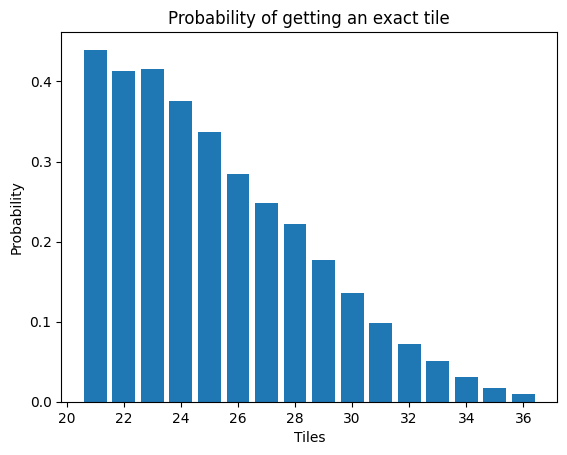

In [14]:
from src import parameters
import matplotlib.pyplot as plt

# Create the bar chart
plt.bar(parameters.TILES, proba_of_tile)

# Create axis labels and title
plt.xlabel('Tiles')
plt.ylabel('Probability')
plt.savefig("assets/proba_bar_chart.png")
plt.title('Probability of getting an exact tile')

# Show the plot
plt.show()

# Full game Pickomino player

We plot here the results of our stochastic gradient descent.

We first plot the evolution of alpha and beta with iterations

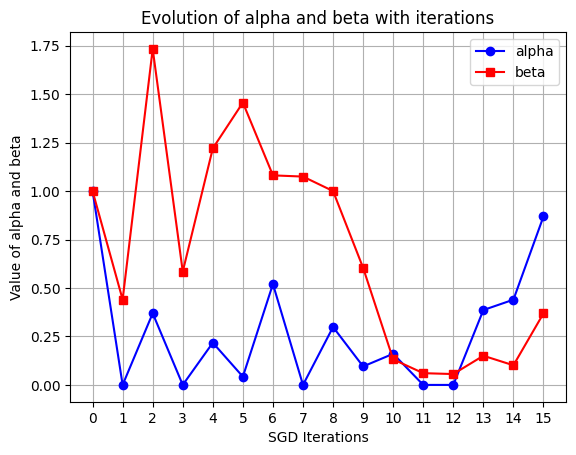

In [68]:
import matplotlib.pyplot as plt

alpha = []
beta = []
game_data = [[],[],[],[]]

def read_data():
    with open("data/sgd_data.txt") as sgd_file:
        for line in sgd_file.readlines():
            line_data = line.split(' ')
            alpha.append(float(line_data[1]))
            beta.append(float(line_data[2]))
            # (games, wins, lost, draws)
            game_data[0].append(float(line_data[3]))
            game_data[1].append(float(line_data[4]))
            game_data[2].append(float(line_data[5]))
            game_data[3].append(float(line_data[3]) - float(line_data[4]) - float(line_data[5]))


def plot_alpha_beta():
    iterations = range(len(alpha))
    plt.plot(iterations, alpha, label='alpha', color='blue', marker='o')
    plt.plot(iterations, beta, label='beta', color='red', marker='s')
    plt.title('Evolution of alpha and beta with iterations')
    plt.xlabel('SGD Iterations')
    plt.ylabel('Value of alpha and beta')
    # Force x-axis ticks to be integers
    plt.xticks(iterations,iterations)
    plt.legend()
    plt.grid(True)
    plt.savefig("assets/alpha_beta.png")
    plt.show()

    
read_data()
plot_alpha_beta()

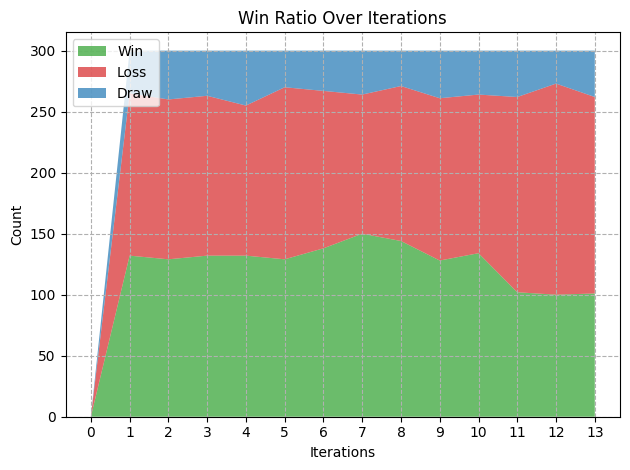

In [67]:
def plot_win_ratio():
    iterations = range(len(alpha))
    
    colors = ['#2ca02c', '#d62728', '#1f77b4'] 
    
    plt.stackplot(iterations, game_data[1], game_data[2], game_data[3], labels=['Win', 'Loss', 'Draw'], colors=colors, alpha=0.7)
    plt.title('Win Ratio Over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Count')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=1)
    # Force x-axis ticks to be integers
    plt.xticks(iterations,iterations)
    plt.savefig("assets/win_ratio.png")
    plt.tight_layout()
    
plot_win_ratio()